In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt


### Hyperparameters

In [2]:
# 클러스터 갯수
K = 3

# 클러스터 당 샘플 갯수
N_k = 100

# 총 샘플 갯수
N = N_k * K

### Sample generation

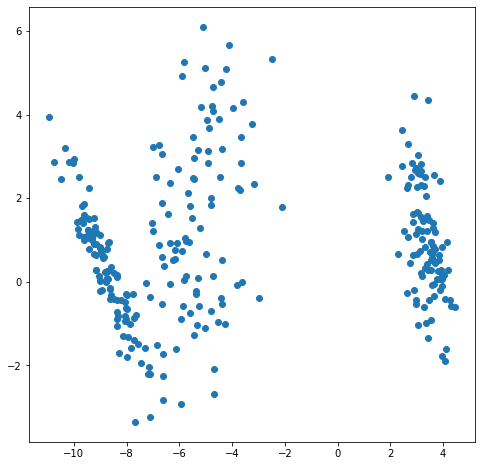

In [3]:
np.random.seed(2020)

samples = []
for _ in range(K):
    # Normal(mean=0, cov=I_2)에서 2D 벡터 하나를 샘플링합니다.
    mean = np.random.normal(size=2) * 5
    
    # wishart distribution에서 샘플링하여 임의의 covariance matrix를 만들어 냅니다.
    cov = scipy.stats.wishart.rvs(2, scale=[[1, 0], [0, 1]])
    
    # 위에서 샘플링한 mean과 covariance를 갖는 multivariate normal distribution에서 N_k개의 샘플을 얻습니다.
    samples.append(np.random.multivariate_normal(mean, cov, size=N_k))
    
# shape: (N, 2), concatenate하여 list를 numpy array로 변환합니다.
samples = np.concatenate(samples, axis=0)

# Visualizaiton
plt.figure(figsize=[8, 8])
plt.scatter(samples[:, 0], samples[:, 1])
plt.show()


### E-step

In [4]:
def E_step(means, samples):
    '''
    각 sample들이 어떤 클러스터에 속할지 결정합니다.
    
    arguments
    means: (K, 2), K개 클러스터의 mean
    samples: (N, 2), N개 샘플들의 벡터
    
    returns
    responsibilities: (N), N개 샘플들이 속할 클러스터의 index
    '''
    
    # shape: (N), 각 샘플들이 속할 클러스터의 index를 저장할 변수를 만듭니다.
    responsibilities = np.zeros(N)

    for n in range(N):
        # shape: (K), 샘플 하나에 대한 K개의 mean들과의 거리를 계산합니다.
        distances = np.sum((means - samples[n]) ** 2, axis=1)
        
        # shape: scalar, 거리가 가장 가까운 mean의 index를 저장합니다.
        responsibilities[n] = np.argmin(distances)
        
    return responsibilities

### M-step

In [5]:
def M_step(responsibilities, samples):
    '''
    E-step에서 정한 클러스터를 기준으로 각각 mean을 구합니다.
    
    arguments
    responsibilities: (N), N개 샘플들이 속할 클러스터의 index
    samples: (N, 2), N개 샘플들의 벡터
    
    returns
    means: (K, 2), K개 클러스터의 mean
    '''
    
    for k in range(K):
        # shape: (N), 각 샘플들이 k번째 클러스터에 속하는지 속하지 않는지 정합니다.
        # 속하면 1, 속하지 않으면 0값을 갖습니다.
        indexes_of_k = (responsibilities == k).astype(float)
        
        # k번째 클러스터에 속하는 샘플들이 있으면
        if np.sum(indexes_of_k) > 0:
            
            # k번째 클러스터에 속하는 샘플들의 mean을 구합니다.
            means[k] = np.sum(samples * indexes_of_k[:, None], axis=0) / np.sum(indexes_of_k)
            
    return means

### EM Iteration

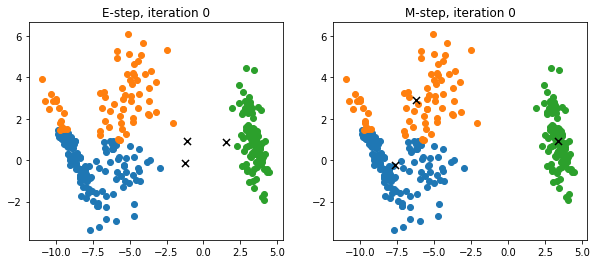

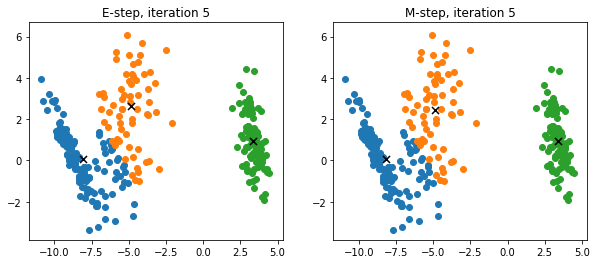

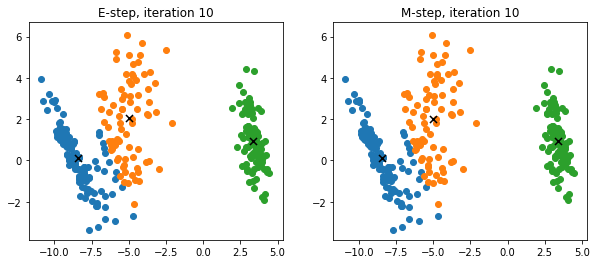

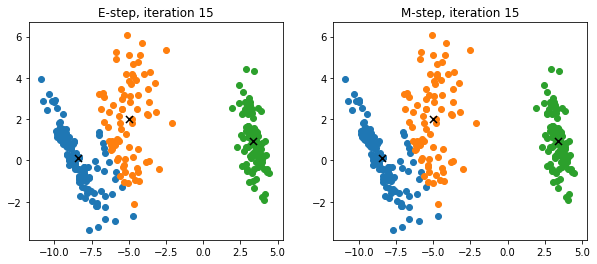

In [9]:
# K개의 mean들을 랜덤하게 초기화합니다.
means = np.random.normal(size=[K, 2])

for step in range(20):
    
    #E-step: 각 sample들이 어떤 클러스터에 속할지 결정합니다.
    responsibilities = E_step(means, samples)
        
    # Visualization
    if step % 5 == 0:
        plt.figure(figsize=[10, 4])
        plt.subplot(1, 2, 1)
        plt.title('E-step, iteration ' + str(step))
        
        # 각 클러스터에 속한 sample들의 벡터를 저장합니다.
        clusters = []
        for k in range(K):
            clusters.append(samples[responsibilities==k])

        for k in range(K):
            # 클러스터 별로 샘플들의 위치를 표시합니다.
            plt.scatter(clusters[k][:, 0], clusters[k][:, 1])
            # 클러스터의 mean위치를 x로 표시합니다.
            plt.scatter(means[k, 0], means[k, 1], color='black', s=50, marker='x')
    
    # M-step: E-step에서 정한 클러스터를 기준으로 각각 mean을 구합니다.
    means = M_step(responsibilities, samples)
      
    # Visualization
    if step % 5 == 0:
        plt.subplot(1, 2, 2)
        plt.title('M-step, iteration ' + str(step))
        for k in range(K):
            plt.scatter(clusters[k][:, 0], clusters[k][:, 1])
            plt.scatter(means[k, 0], means[k, 1], color='black', s=50, marker='x')

        plt.show()

